In [10]:
# Data update functionality
import os

from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
hosts = ["52.13.145.44", "52.89.179.9", "54.191.161.231", "54.218.172.167", "54.218.29.151", "54.245.161.6","54.189.189.146","34.221.228.54"]
key_file_loc = "~/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/"

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root):
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-Exploration_1-random_inputs/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [49]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
d6341e30912f: Already exists
d6341e30912f: Already exists
087a57faf949: Already exists
087a57faf949: Already exists
5d71636fb824: Already exists
5d71636fb824: Already exists
0c1db9598990: Already exists
2eeb5ce9b924: Already exists
0c1db9598990: Already exists
2eeb5ce9b924: Already exists
5b17b6f4d4e0: Already exists
f1abee0af377: Already exists
298587aefca5: Already exists
d19a52a4201b: Already exists
5b17b6f4d4e0: Already exists
f1abee0af377: Already exists
298587aefca5: Already exists
d19a52a4201b: Already exists
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
c4b97e37313f: Already exists
d6341e30912f: Already exists
0.0.1-SNAPSHOT: Pulling from beammodel/beam-competition
54f7e8ac135a: Already exists
c4b97e37313f: Already ex

01556cb5c24d: Already exists
59cec1e23469: Already exists
a4e8cfda4e7e: Already exists
c2c7d8e9c50f: Already exists
26431a57825a: Already exists
916606cef963: Already exists
77e7c1d02cf0: Already exists
fbaced5f3ab6: Already exists
da3c75a71849: Already exists
2c15ce938ad2: Already exists
4cef7fc3dfe3: Already exists
a0dd5a72f852: Already exists
25f9d1f0e84f: Already exists
2dc6660ce23e: Already exists
fcaae21800f6: Already exists
d55b7d5e9cd0: Already exists
84aaad049cf8: Already exists
3a94857599e1: Already exists
4e6d5373fac6: Pulling fs layer
68a61d2aa4da: Pulling fs layer
68a61d2aa4da: Verifying Checksum
68a61d2aa4da: Download complete
68a61d2aa4da: Verifying Checksum
68a61d2aa4da: Download complete
4e6d5373fac6: Verifying Checksum
4e6d5373fac6: Download complete
4e6d5373fac6: Verifying Checksum
4e6d5373fac6: Download complete
4e6d5373fac6: Pull complete
4e6d5373fac6: Pull complete
68a61d2aa4da: Pull complete
Digest: sha256:a97abe110bf0b04173f5954f90485ee47c0c7e1d3a019a331b654ec8c

{<Connection host=52.13.145.44 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.29.151 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.191.161.231 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=52.89.179.9 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=34.221.228.54 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.218.172.167 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.245.161.6 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>,
 <Connection host=54.189.189.146 user=ubuntu>: <Result cmd='docker pull beammodel/beam-competition:0.0.1-SNAPSHOT' exited=0>}

In [5]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root) for hostname, host_ip in zip(host_names, hosts)]

[0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
import pandas as pd, numpy as np, seaborn as sns
import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [12]:
%matplotlib inline

In [13]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

In [14]:
class InputScoreData:
    def __init__(self,input_name, input_df, score_df):
        self.input_name = input_name
        self.input_df  = input_df
        self.score_df = score_df

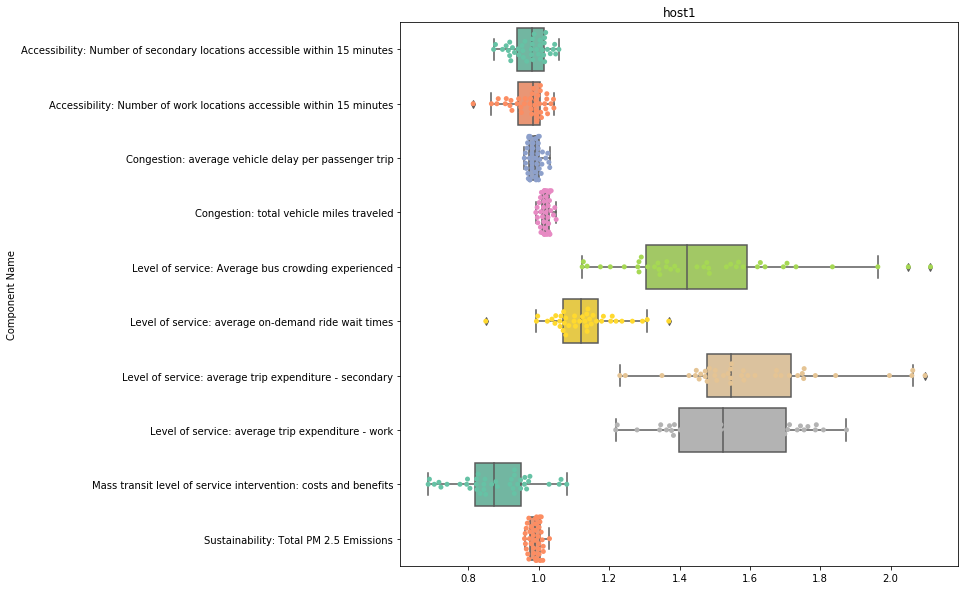

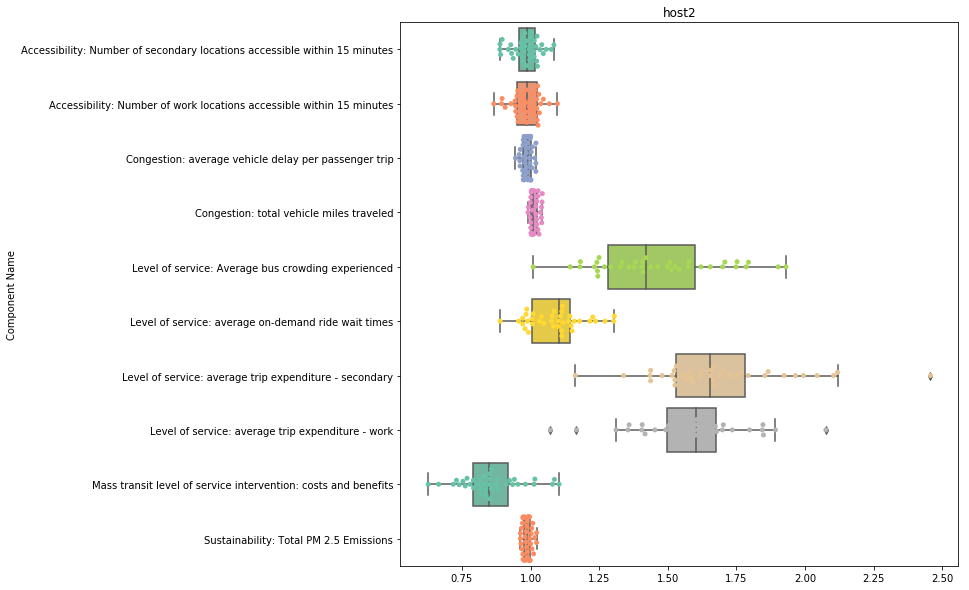

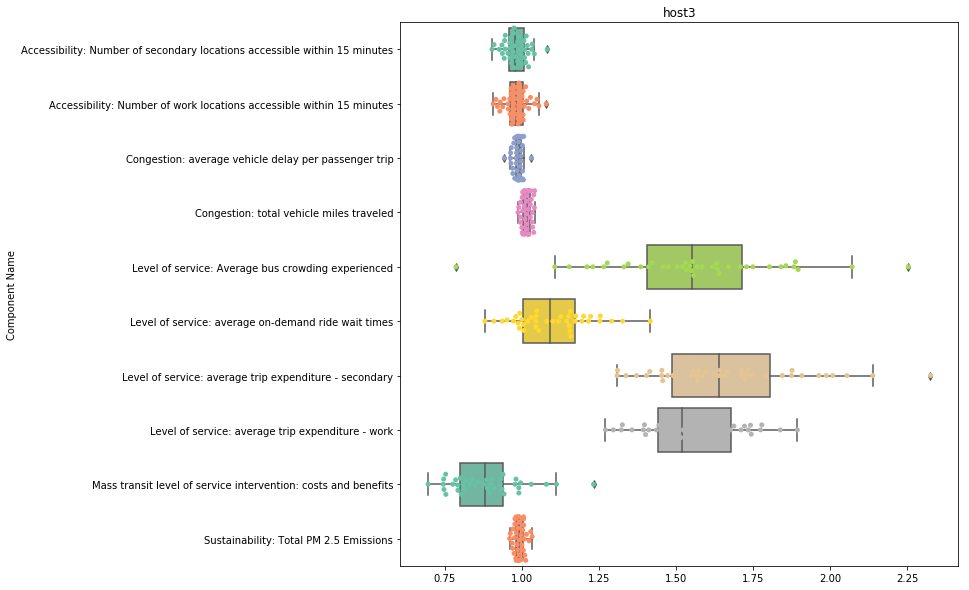

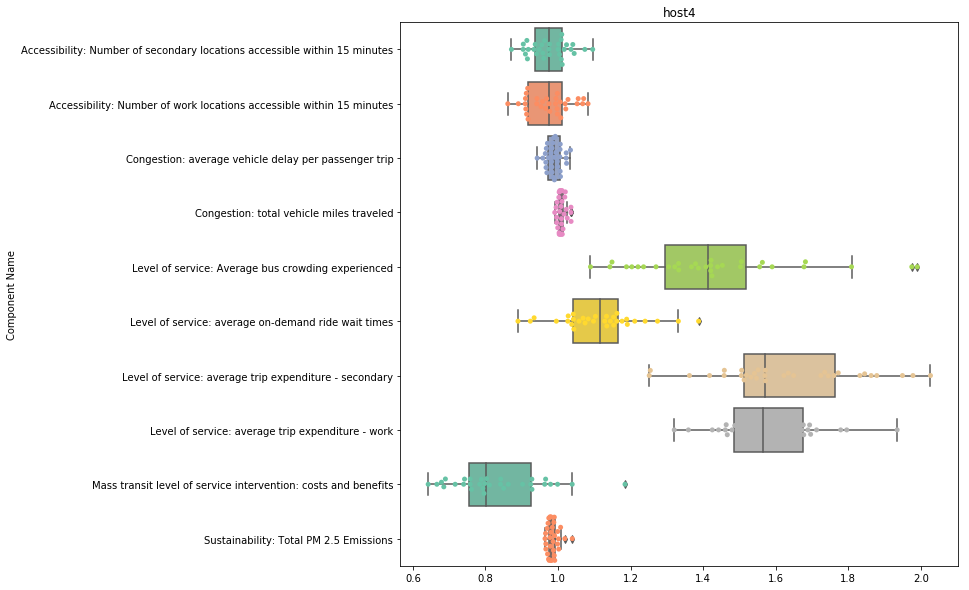

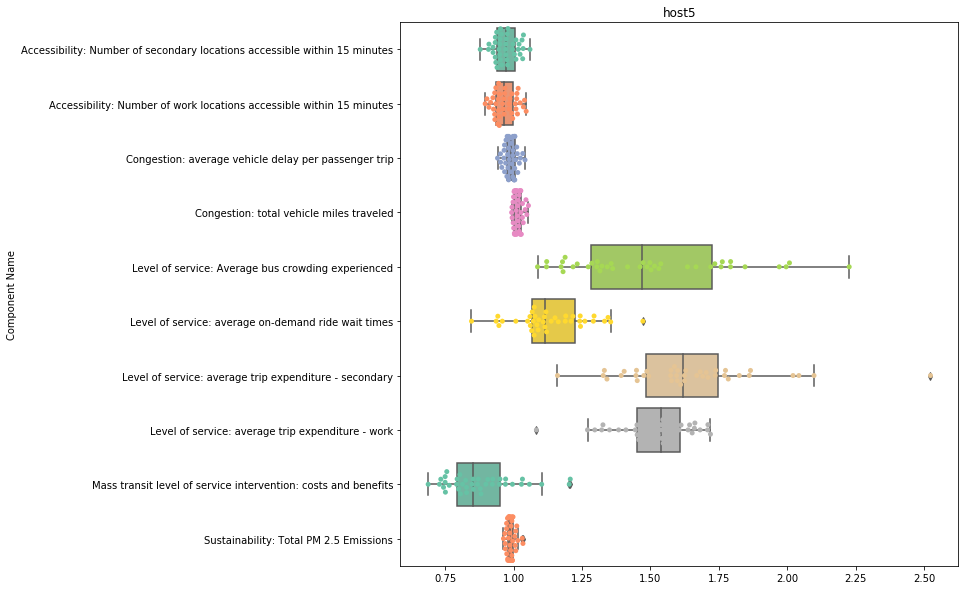

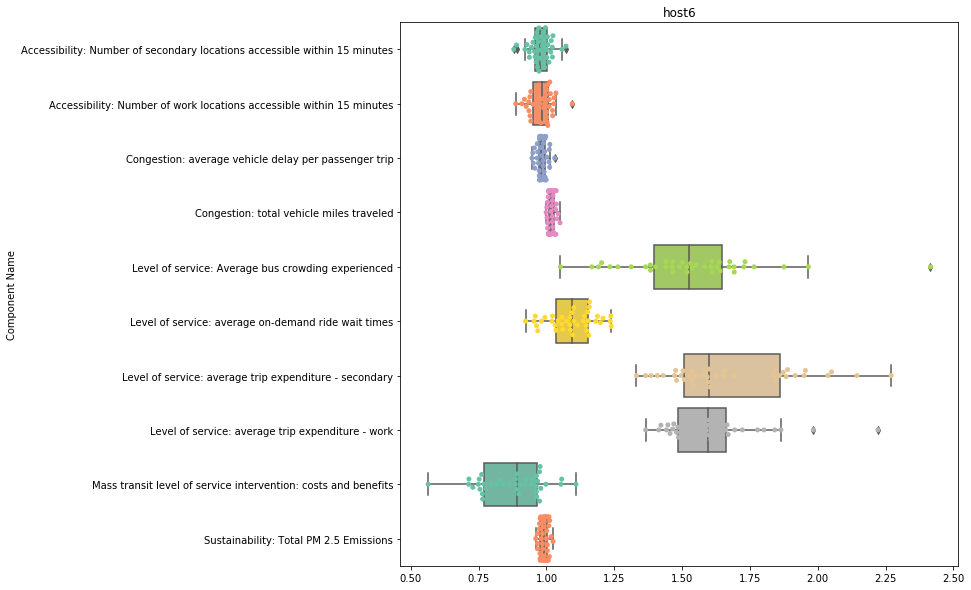

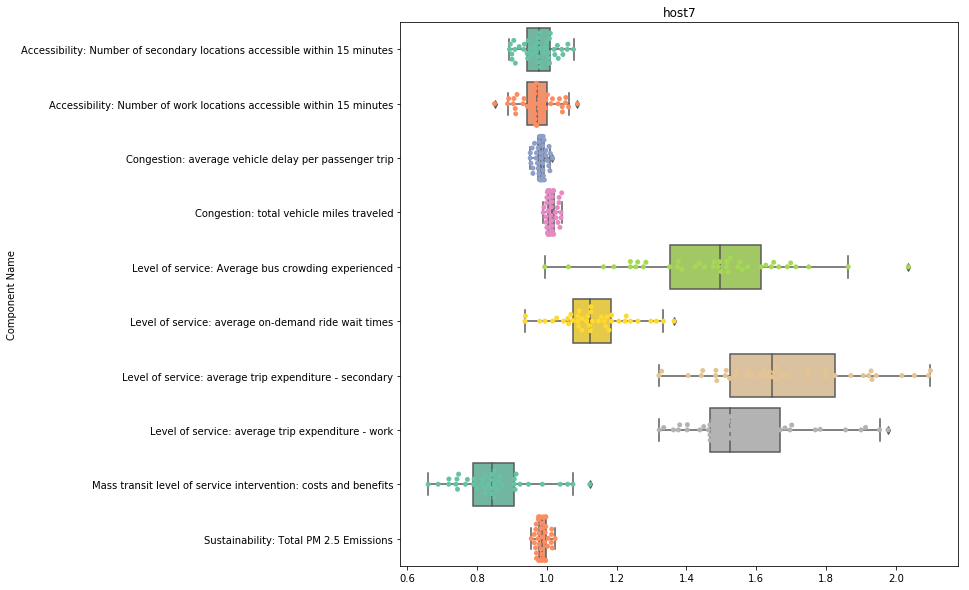

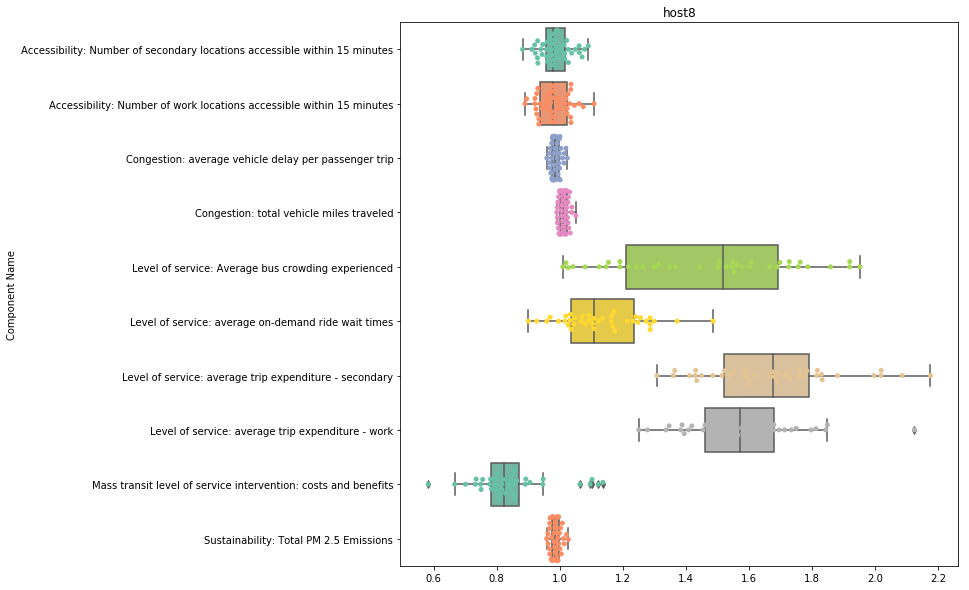

In [15]:
# collect, parse, and concatenate scores as well as plot by condition
import glob

scores_dfs={}
for host in host_names:
    common="../search-output/random-all/{}/".format(host)
    output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


    sub_score_dfs = []
    all_input_dfs = defaultdict(list)
    SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
    SUB_SCORE_NAME = "submissionScores.csv"
    input_names = ("FrequencyAdjustment","ModeIncentives","PtFares","VehicleFleetMix")

    for output_dir in output_dirs:
        # Load sub_score_dfs
        sub_score_file = output_dir + SUB_SCORE_NAME
        if not Path(sub_score_file).is_file():
            continue
        score_df = pd.read_csv(sub_score_file,index_col="Component Name")
        output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
        if "RS" not in output_key:  # filter out old runs for now
            continue
        score_df["output_key"] = output_key
        sub_score_dfs.append(score_df[["Raw Score","output_key"]])

        for input_name in input_names:
            input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
            if input_name == 'ModeIncentives':
                input_df = pd.read_csv(input_file,dtype={'age':str})
            else:
                input_df = pd.read_csv(input_file)
            if input_df.shape[0] == 0:
                continue
            input_df["output_key"] = output_key
            input_df.index.name = 'obs_num'
            all_input_dfs[input_name].append(input_df)


    freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
    mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
    ptfare_df = concat_and_set_index(all_input_dfs,"PtFares")
    vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

    trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
    freq_df.loc[:,"trip_id"]=trip_id_factors[0]

    mode_factors = pd.factorize(mode_df.loc[:,"mode"])
    mode_df.loc[:,"mode"]=mode_factors[0]

    a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
    mapping = dict(zip(b,a))
    ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
    vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

    vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
    vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

    input_type = "ModeIncentives"
    input_fields = ["income","age"]
    mode_df = split_input_range(mode_df.copy(),input_fields)

    input_type = "PtFares"
    input_fields = ["age"]
    ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

    scores_df = pd.concat(sub_score_dfs)

    score_type = "Submission Score"
    freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
    mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
    ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
    vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

    freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
    scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
    scores_dfs[host] = scores_df_wide
    fig = plt.figure(figsize=(10,10))
    sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
    sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
    axis = fig.axes[0]
#     axis.set_xlim(-0.25,5.0)
    plt.title(host)
    plt.show()
    fig.savefig("img/{}.png".format(host),format="png",dpi=150)

In [17]:
wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
wide_scores.to_csv('wide_scores.csv')

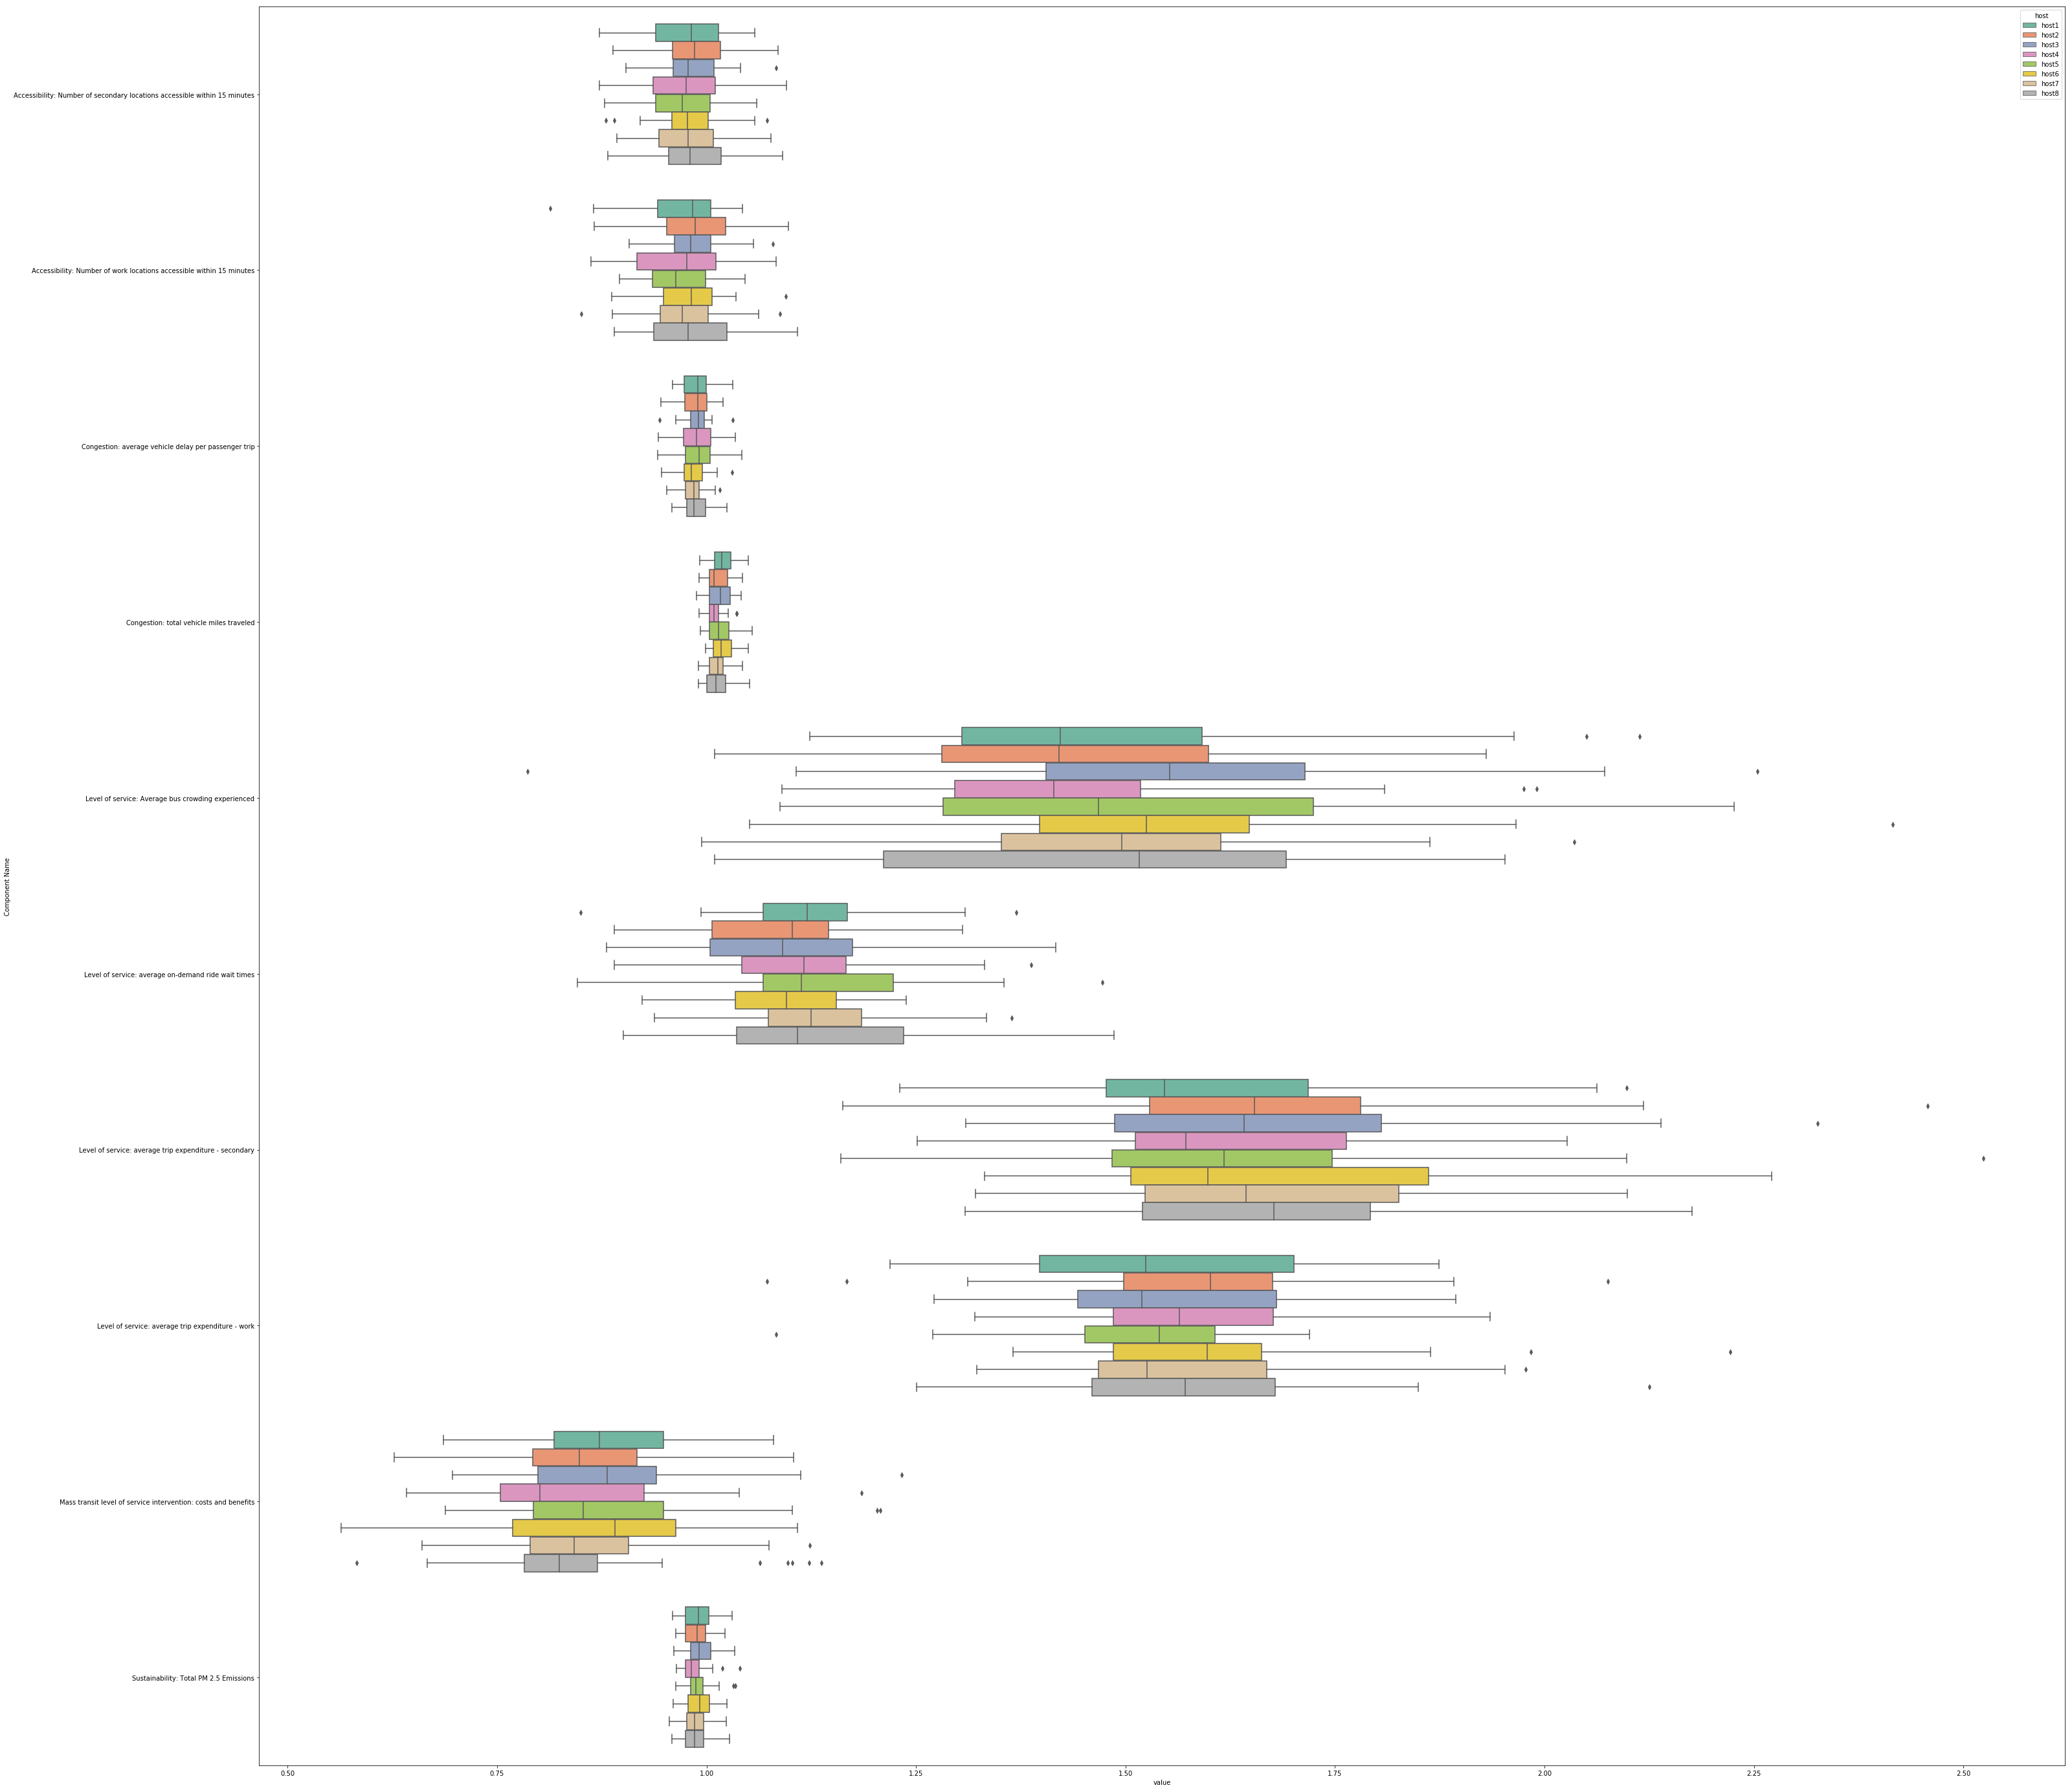

In [16]:
# Create grouped plot
for k,df in scores_dfs.items():
    df['host'] = k
    
grouped = pd.concat(list(scores_dfs.values()))
melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
fig = plt.figure(figsize=(50,50))

sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
fig.savefig('img/grouped.png',dpi=300)

In [18]:
from pandas.plotting import parallel_coordinates

In [ ]:
para

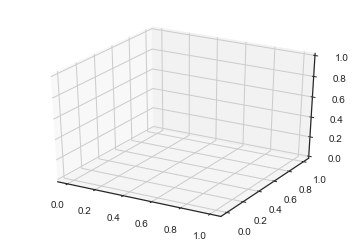

In [108]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(freq_subscore_df['trip_id'], freq_subscore_df['headway_secs'], freq_subscore_df['start_time'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()

In [75]:
sub_score_df=sub_score_df.set_index('output_key')
sub_score_df.index.name = 'output_key'

NameError: name 'sub_score_df' is not defined

In [76]:
freq_df=pd.merge(sub_scores["a"],input_db["VehicleFleetMix"],how="outer",right_index=True,left_on=[("output_key")])

NameError: name 'sub_scores' is not defined

In [77]:
freq_df

,trip_id,start_time,end_time,headway_secs
output_key,,,,
1to8baq_,0,29400,67080,5460
1to8baq_,1,0,4140,2160
1to8baq_,2,1740,18360,6480
1to8baq_,3,37680,46320,5460
1to8baq_,4,68580,79320,2820
1to8baq_,5,16680,57060,4200
1to8baq_,6,9240,53940,4500
1to8baq_,7,42600,67680,6480
1to8baq_,8,45780,82080,1920


In [78]:
test_df=freq_df.loc[:,'Weighted Score':].reset_index(drop=True).drop('output_key',axis=1)

KeyError: 'Weighted Score'

In [306]:
test_df["Weighted Score"].describe()

count    1040.000000
mean     1179.355861
std      1450.967800
min         0.000000
25%       271.386123
50%       686.453723
75%      1530.935567
max      7697.940789
Name: Weighted Score, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d9bfef0>,
      dtype=object)

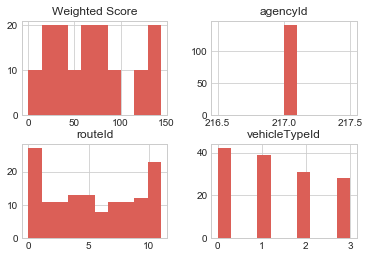

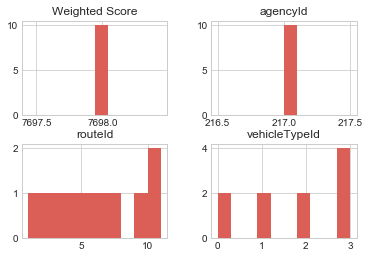

In [310]:
test_df[test_df["Weighted Score"]<150].hist()
test_df[test_df["Weighted Score"]>7030].hist()

-25.328436022934504

In [308]:
test_df[test_df["Weighted Score"]>1571]

,Weighted Score,agencyId,routeId,vehicleTypeId
60,2442.538930,217,10,3
61,2442.538930,217,6,2
62,2442.538930,217,0,1
63,2442.538930,217,9,2
64,2442.538930,217,3,2
65,2442.538930,217,5,1
66,2442.538930,217,11,3
67,2442.538930,217,1,3
68,2442.538930,217,4,1
69,2442.538930,217,2,0
